Note: I ran this on my local computer, so any file paths will need to change to run on Colab. Anything else should work, though. I think...

Data: https://www.kaggle.com/hsankesara/flickr-image-dataset

In [1]:
import PIL
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from collections import defaultdict

# Model Setup

## Run dataset through VGG16 or ResNet50 trained with imageNet

#### This doesn't need to be run every time! Use the saved npy files generated by this code.

In [19]:
# Valid model types are currently 'ResNet50' or 'VGG16'
modelType = 'VGG16'
dataDir = 'C:/Users/antwo/Desktop/CMPE256_Project/data_phil/'

In [20]:
img_height = 224
img_width = 224
batch_size = 32
# num_train_samples = 2

# datagen = ImageDataGenerator(rescale = 1. / 255)
if (modelType == 'VGG16'):
    datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
    model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
    outputLen = 25088
elif (modelType == 'ResNet50'):
    datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
    model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
    outputLen = 100352
else:
    raise ValueError('ERROR: Invalid model type.')
    
generator = datagen.flow_from_directory(
    dataDir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = None,
    shuffle = False)

# for i in generator.filenames:
#   print(i)

Found 1 images belonging to 1 classes.


In [21]:
extracted_features = model.predict(generator)

# extracted_features = model.predict(img)
print(np.shape(extracted_features))

(1, 7, 7, 512)


In [22]:
ids = []
for name in generator.filenames:
    ids.append(name[(name.find("\\")+1):name.find(".jpg")])

In [23]:
extracted_features_reshape = extracted_features.reshape(np.shape(extracted_features)[0], outputLen)
print(np.shape(extracted_features_reshape))

(1, 25088)


### Load the previously saved arrays and break them up into smaller chunks.

In [ ]:
features_l = np.load('./flickr30k_ResNet_features.npy')
ids_l = np.load('./flickr30k_ResNet_ids.npy')

In [ ]:
cnt = 0
entriesPerFile = 1000
# featureArr = np.empty((1000, np.shape(features_l)[1]), dtype=type(features_l[0, 0]))
# idArr = np.empty((1000), dtype=type(ids_l[0]))

# for (id, vec) in zip(features_l, ids_l):
while (cnt * entriesPerFile < len(ids_l)):
    start = cnt * entriesPerFile
    end = cnt * entriesPerFile + entriesPerFile
    if (end > len(ids_l)):
        end = len(ids_l)
        
    # print(f'start = {start}, end = {end}')
        
    with open(f'./resnet_features_{cnt:03d}.npy', 'wb') as f:
        np.save(f, features_l[start:end, :])
        
    with open(f'./resnet_ids_{cnt:03d}.npy', 'wb') as f:
        np.save(f, ids_l[start:end])
        
    cnt += 1

In [ ]:
foo = np.load('./resnet_features_001.npy')
print(foo[0:5, 1])
print(np.shape(foo))

bar = np.load('./resnet_ids_001.npy')
print(np.shape(bar))

In [ ]:
print(np.shape(ids_l))
for i in range(10):
    print(ids_l[i])
    

# Generate Signatures from Random Projections

Load some data.

In [7]:
features = extracted_features_reshape
# ids = 
numImages = np.shape(features)[0]

In [37]:
# features = np.load('C:/Users/antwo/Desktop/CMPE256_Project/output/roadTrip_ResNet50_features.npy')
# ids = np.load('C:/Users/antwo/Desktop/CMPE256_Project/output/roadTrip_ResNet50_ids.npy')
# features = np.load('C:/Users/antwo/Desktop/CMPE256_Project/output/flickr30k_ResNet50_features.npy')
# ids = np.load('C:/Users/antwo/Desktop/CMPE256_Project/output/flickr30k_ResNet50_ids.npy')
features = np.load('C:/Users/antwo/Desktop/CMPE256_Project/output/flickr30k_VGG16_features.npy')
ids = np.load('C:/Users/antwo/Desktop/CMPE256_Project/output/flickr30k_VGG16_ids.npy')

numImages = np.shape(features)[0]

Create hyperplanes to segment our data space and create signatures.

In [8]:
# Random Projections source: https://www.pinecone.io/learn/locality-sensitive-hashing-random-projection/

signatureLen = 200
hyperPlaneDim = np.shape(features)[1]
print(f'Sig len = {signatureLen}, hyperplane dim = {hyperPlaneDim}')

# np.random.seed(120)
planeNorms = np.random.rand(signatureLen, hyperPlaneDim) - 0.5
# print(planeNorms)

Sig len = 200, hyperplane dim = 25088


Find the signature for each image.

In [9]:
sigMat = np.empty((signatureLen, numImages), dtype=int)

for idx, vec in enumerate(features):
    sig = np.dot(vec, planeNorms.T)
    sig = sig > 0
    sig = sig.astype(int)
    sigMat[:, idx] = sig
    
# sigMat = sigMat > 0
# sigMat = sigMat.astype(int)
    
# print(sigMat)

# sig0 = np.dot(features[0], planeNorms.T)
# sig0 = sig0 > 0
# sig0 = sig0.astype(int)
# print(sig0)
# sigMat[:, 0] = sig0
# print(sigMat[:, 0])

In [10]:
print(np.shape(sigMat))
print(sigMat[0, 0])

(200, 31783)
1


### Hash the signatures into buckets.

#### Multi-band approach

In [38]:
# Will split the signature matrix into b bands of r rows each.
b = 20
r = int(signatureLen / b)

In [39]:
bands = np.empty((b, r, np.shape(sigMat)[1]), dtype=int)
# print(np.shape(bands))
dictList = []

def DefaultValue():
    return []

for band in range(0, b):
    bands[band, :, :] = sigMat[band*r : band*r+r, :]

# For hashing, let's try using a Python dictionary. Put all columns in the band into the dictionary with
# the key being the signature in the band and the value being a list of all columns that have that key.
# Then, can just check which other columns hashed to the same key as the column of interest.
for (idx, band) in enumerate(bands):
    # Add all signatures in the band to a hash table (dictionary).
    dictList.append(defaultdict(DefaultValue))
    for sigIdx in range(0, np.shape(band)[1]):
        # sig = tuple(band[:, sigIdx].tolist())
        # print(band[:, sigIdx])
        sig = ''.join(band[:, sigIdx].astype(str))
        # print(sig)
        dictList[idx][sig].append(sigIdx)


In [40]:
def EuclidDistance(v1, v2):
    sum = 0
    for i in range(len(v1)):
        sum += np.square(v1[i] - v2[i])

    d = np.sqrt(sum)
    return d

##### Search for all images similar to a target input

In [41]:
def SearchForSimilar(dictList, targetSig, b, r):
    candidates = set()

    for band in range(b):
        targetBandSig = targetSig[band * r : band * r + r]
        targetBandSig = ''.join(targetBandSig.astype(str))
        for item in dictList[band][targetBandSig]:
            candidates.add(item)
            
    return candidates

In [42]:
targetInDataset = False
# targetDir = 'C:/Users/antwo/Desktop/CMPE256_Project/data_mine/images/'
# targetDir = 'C:/Users/antwo/Desktop/CMPE256_Project/data/flickr30k_images/'
targetDir = 'C:/Users/antwo/Desktop/CMPE256_Project/data_phil/rorschach/'
dataDir = 'C:/Users/antwo/Desktop/CMPE256_Project/data/flickr30k_images/'
# targetName = '33497646'
targetName = '09'
target = PIL.Image.open(targetDir + targetName + '.jpg')

if (targetInDataset):
    for i in range(len(ids)):
        if (ids[i] == targetName):
            # print(i)
            targetIdx = i
    targetFeatures = features[targetIdx]
    
else:
    targetFeatures = extracted_features_reshape[0]
    
targetSig = np.dot(targetFeatures, planeNorms.T)
targetSig = targetSig > 0
targetSig = targetSig.astype(int)

candidates = SearchForSimilar(dictList, targetSig, b, r)
print(len(candidates))
# print(candidates)

1201


Good input: flickr image = 33497646, sigLen = 200, b = 20, ResNet, show top 10

Target:


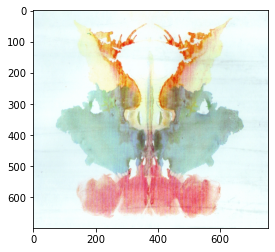

0
Image = 7802432164, index = 30767, distance = 1590.4910993450867


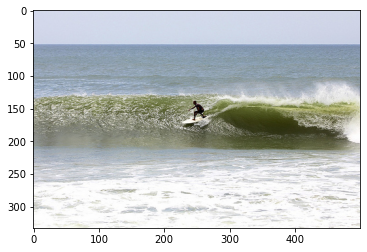

1
Image = 1277185009, index = 834, distance = 1600.5915156504418


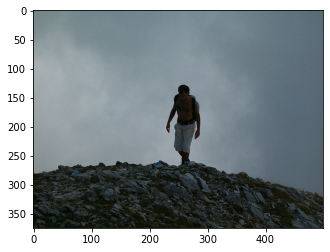

2
Image = 7596563530, index = 30439, distance = 1601.303977076611


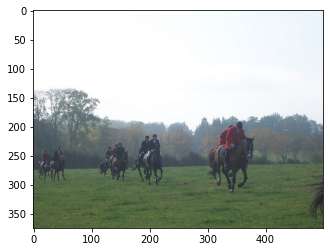

3
Image = 4953541345, index = 25546, distance = 1607.749555243465


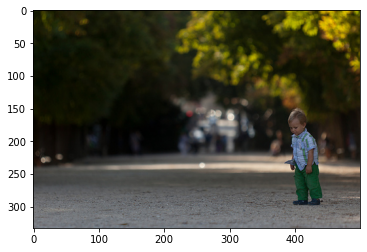

4
Image = 3656206975, index = 16126, distance = 1609.5777267268772


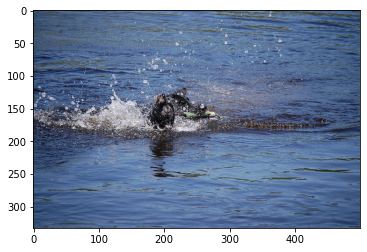

5
Image = 7243489604, index = 29984, distance = 1631.7663277946137


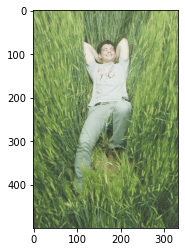

6
Image = 2076865206, index = 3233, distance = 1653.0894361566532


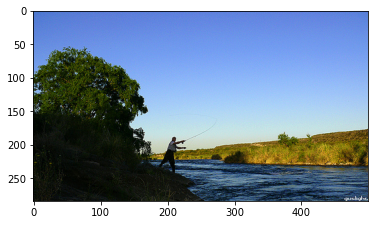

7
Image = 525863257, index = 26557, distance = 1654.2803963921774


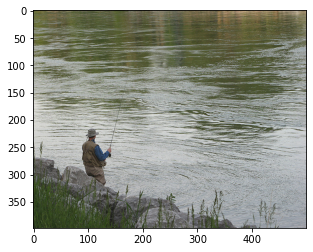

8
Image = 3070485870, index = 10915, distance = 1661.1532476166806


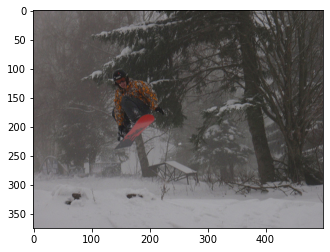

9
Image = 6919935331, index = 29413, distance = 1662.1917767785744


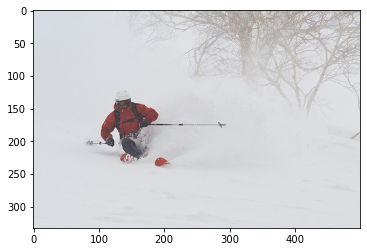

In [43]:
print('Target:')
plt.imshow(target)
plt.show()

showAll = False
onlyShowTop = True
numToShow = 10
stopAfter = 0
cnt = 0

if (onlyShowTop):
    # Generate sorted list of candidate distances.
    distances = []
    for c in candidates:
        dist = EuclidDistance(features[c], targetFeatures)
        distances.append((c, dist))
        
    distances.sort(key = lambda x: x[1])
    # print(distances)
    
    if (numToShow > len(distances)):
        numToShow = len(distances)
    
    for i in range(numToShow):
        print(f'Image = {ids[distances[i][0]]}, index = {distances[i][0]}, distance = {distances[i][1]}')
        img = PIL.Image.open(dataDir + f'{ids[distances[i][0]]}.jpg')
        plt.imshow(img)
        plt.show()
    
else:
    for c in candidates:
        if (showAll):
            print(f'Image = {ids[c]}, index = {c}')
            img = PIL.Image.open(dataDir + f'{ids[c]}.jpg')
            plt.imshow(img)
            plt.show()

        else:
            dist = EuclidDistance(features[c], targetFeatures)
            if (dist < 650):
                print(f'Image = {ids[c]}, index = {c}, distance = {dist}')
                img = PIL.Image.open(dataDir + f'{ids[c]}.jpg')
                plt.imshow(img)
                plt.show()

        cnt += 1
        if (cnt > stopAfter and stopAfter != 0):
            break

##### Search for all similar pairs in dataset

In [ ]:
idx = 120
print(EuclidDistance(features[110], features[idx]))
img = PIL.Image.open(f'C:/Users/antwo/Desktop/CMPE256_Project/data_mine/images/{ids[idx]}.jpg')
plt.imshow(img)
plt.show()

In [ ]:
def SearchForCandidatePairs(dictList):
    # Check for candidate pairs by checking the buckets in which an image ended up.
    candidates = set()

    for d in dictList:
        for key in d:
            if (len(d[key]) > 1):
                # print('foo')
                for i in range(0, len(d[key])):
                    for k in range(i+1, len(d[key])):
                        candidates.add(frozenset((d[key][i], d[key][k])))
    
    return candidates

candidates = SearchForCandidatePairs(dictList)

print(len(candidates))

In [ ]:
for pairSet in candidates:
    pair = list(pairSet)
    if (EuclidDistance(features[pair[0]], features[pair[1]]) < 800):
        print('Similar images?')
        for idx in pair:
            print(f'Image = {ids[idx]}, index = {idx}')
            img = PIL.Image.open(f'C:/Users/antwo/Desktop/CMPE256_Project/data_mine/images/{ids[idx]}.jpg')
            plt.imshow(img)
            plt.show()

#### Single-band approach

In [ ]:
def DefaultValue():
    return []

buckets = defaultdict(DefaultValue)
for idx, sig in enumerate(sigMat.T):
    hashStr = ''.join(sig.astype(str))
    buckets[hashStr].append(idx)

In [ ]:
print(len(buckets.keys()))
for k, v in buckets.items():
    if (len(v) > 1):
        print('Similar images?')
        for idx in v:
            print(f'Image = {ids[idx]}, index = {idx}')
            img = PIL.Image.open(f'C:/Users/antwo/Desktop/CMPE256_Project/data_mine/images/{ids[idx]}.jpg')
            plt.imshow(img)
            plt.show()

In [ ]:
p1 = features[157]
p2 = features[432]

sum = 0
for i in range(len(p1)):
    sum += np.square(p1[i] - p2[i])
    
d = np.sqrt(sum)
print(d)

p1 = features[323]
p2 = features[612]

sum = 0
for i in range(len(p1)):
    sum += np.square(p1[i] - p2[i])
    
d = np.sqrt(sum)
print(d)